# Operations on Word Vectors



## Table of Contents

- [Packages](#0)
- [1 - Load the Word Vectors](#1)
- [2 - Embedding Vectors Versus One-Hot Vectors](#2)
- [3 - Cosine Similarity](#3)
- [4 - Word Analogy Task](#4)
- [5 - Debiasing Word Vectors](#5)
    - [5.1 - Neutralize Bias for Non-Gender Specific Words](#5-1)
    - [5.2 - Equalization Algorithm for Gender-Specific Words](#5-2)
- [6 - References](#6)

<a name='0'></a>
## Packages


In [ ]:
import numpy as np
from w2v_utils import *

<a name='1'></a>
## 1 - Load the Word Vectors

I used 50-dimensional GloVe vectors to represent words.


In [ ]:
words, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

So far I've loaded:
- `words`: set of words in the vocabulary.
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

<a name='2'></a>
## 2 - Embedding Vectors Versus One-Hot Vectors
One-hot vectors don't do a good job of capturing the level of similarity between words. This is because every one-hot vector has the same Euclidean distance from any other one-hot vector.

Embedding vectors, such as GloVe vectors, provide much more useful information about the meaning of individual words.  

<a name='3'></a>
## 3 - Cosine Similarity

To measure the similarity between two words, we need a way to measure the degree of similarity between two embedding vectors for the two words. Given two vectors $u$ and $v$, cosine similarity is defined as follows:

$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

* $u \cdot v$ is the dot product (or inner product) of two vectors
* $||u||_2$ is the norm (or length) of the vector $u$
* $\theta$ is the angle between $u$ and $v$.
* The cosine similarity depends on the angle between $u$ and $v$.
    * If $u$ and $v$ are very similar, their cosine similarity will be close to 1.
    * If they are dissimilar, the cosine similarity will take a smaller value.

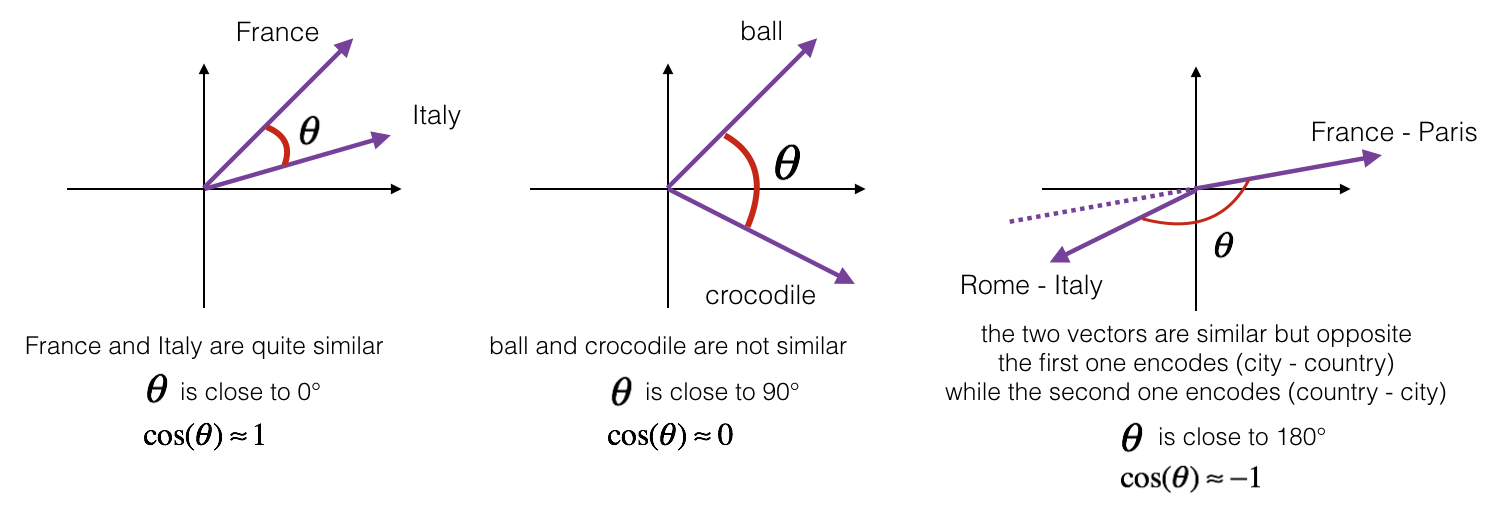

In [ ]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similarity between u and v

    Arguments:
        u -- a word vector of shape (n,)
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """

    # Special case. Consider the case u = [0, 0], v=[0, 0]
    if np.all(u == v):
        return 1

    # Compute the dot product between u and v
    dot = np.dot(u, v)
    # Compute the L2 norm of u
    norm_u = np.sqrt(np.sum(u**2))

    # Compute the L2 norm of v
    norm_v = np.sqrt(np.sum(v**2))

    # Avoid division by 0
    if np.isclose(norm_u * norm_v, 0, atol=1e-32):
        return 0

    # Compute the cosine similarity defined by formula
    cosine_similarity = dot / (norm_u * norm_v)

    return cosine_similarity

<a name='4'></a>
## 4 - Word Analogy Task

* In the word analogy task, complete this sentence:  
    <font color='brown'>"*a* is to *b* as *c* is to **____**"</font>.

* An example is:  
    <font color='brown'> '*man* is to *woman* as *king* is to *queen*' </font>.

* We're trying to find a word *d*, such that the associated word vectors $e_a, e_b, e_c, e_d$ are related in the following manner:   
    $e_b - e_a \approx e_d - e_c$
* Measure the similarity between $e_b - e_a$ and $e_d - e_c$ using cosine similarity.


In [ ]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    Performs the word analogy task as explained above: a is to b as c is to ____.

    Arguments:
    word_a -- a word, string
    word_b -- a word, string
    word_c -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors.

    Returns:
    best_word --  the word such that v_b - v_a is close to v_best_word - v_c, as measured by cosine similarity
    """

    # convert words to lowercase
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()

    # Get the word embeddings e_a, e_b and e_c
    e_a, e_b, e_c = word_to_vec_map.get(word_a), word_to_vec_map.get(word_b), word_to_vec_map.get(word_c)

    words = word_to_vec_map.keys()
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None, it will help keep track of the word to output

    # loop over the whole word vector set
    for w in words:
        # to avoid best_word being one the input words, skip the input word_c
        # skip word_c from query
        if w == word_c:
            continue

        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)
        cosine_sim = cosine_similarity(e_b - e_a, word_to_vec_map[w] - e_c)

        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w

    return best_word

In [ ]:
triads_to_try = [('italy', 'italian', 'spain'), ('india', 'delhi', 'japan'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]
for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad, word_to_vec_map)))

italy -> italian :: spain -> spanish
india -> delhi :: japan -> tokyo
man -> woman :: boy -> girl
small -> smaller :: large -> smaller


<font color='blue'>
    <b>Takeaways</b>:

- Cosine similarity is a good way to compare the similarity between pairs of word vectors.
    - L2 (Euclidean) distance also works.
- For NLP applications, using a pre-trained set of word vectors is often a good way to get started. </font>


<a name='5'></a>
## 5 - Debiasing Word Vectors

Here I examined gender biases that can be reflected in a word embedding, and explored algorithms for reducing the bias.

First, let's see how the GloVe word embeddings relate to gender. I began by computing a vector $g = e_{woman}-e_{man}$, where $e_{woman}$ represents the word vector corresponding to the word *woman*, and $e_{man}$ corresponds to the word vector corresponding to the word *man*. The resulting vector $g$ roughly encodes the concept of "gender".

We might get a more accurate representation if we compute $g_1 = e_{mother}-e_{father}$, $g_2 = e_{girl}-e_{boy}$, etc. and average over them, but just using $e_{woman}-e_{man}$ will give good enough results for now.


In [ ]:
g = word_to_vec_map['woman'] - word_to_vec_map['man']
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


Now, we consider the cosine similarity of different words with $g$ - What does a positive value of similarity mean, versus a negative cosine similarity?

In [ ]:
print ('List of names and their similarities with constructed vector:')

# girls and boys name
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

List of names and their similarities with constructed vector:
john -0.23163356145973724
marie 0.315597935396073
sophie 0.3186878985941878
ronaldo -0.31244796850329437
priya 0.17632041839009402
rahul -0.16915471039231722
danielle 0.24393299216283895
reza -0.07930429672199553
katy 0.2831068659572615
yasmin 0.23313857767928753


Female first names tend to have a positive cosine similarity with our constructed vector $g$, while male first names tend to have a negative cosine similarity. This is not surprising, and the result seems acceptable.

In [ ]:
print('Other words and their similarities:')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist',
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

Other words and their similarities:
lipstick 0.27691916256382665
guns -0.1888485567898898
science -0.06082906540929699
arts 0.008189312385880344
literature 0.0647250443345993
warrior -0.20920164641125288
doctor 0.11895289410935045
tree -0.07089399175478092
receptionist 0.3307794175059374
technology -0.13193732447554293
fashion 0.035638946257727
teacher 0.1792092343182567
engineer -0.08039280494524072
pilot 0.0010764498991917074
computer -0.10330358873850498
singer 0.18500518136496297


These results reflect certain unhealthy gender stereotypes. For example, we see “computer” is negative and is closer in value to male first names, while “literature” is positive and is closer to female first names.

Below I aimed to reduce the bias of these vectors, using an algorithm due to [Boliukbasi et al., 2016](https://arxiv.org/abs/1607.06520). Some word pairs such as "actor"/"actress" or "grandmother"/"grandfather" should remain gender-specific, while other words such as "receptionist" or "technology" should be neutralized, i.e. not be gender-related. I treated these two types of words differently when debiasing.

<a name='5-1'></a>
### 5.1 - Neutralize Bias for Non-Gender Specific Words

The figure below helps visualize what neutralizing does. If we're using a 50-dimensional word embedding, the 50 dimensional space can be split into two parts: The bias-direction $g$, and the remaining 49 dimensions, which is called $g_{\perp}$ here. In linear algebra, we say that the 49-dimensional $g_{\perp}$ is perpendicular (or "orthogonal") to $g$, meaning it is at 90 degrees to $g$. The neutralization step takes a vector such as $e_{receptionist}$ and zeros out the component in the direction of $g$, giving us $e_{receptionist}^{debiased}$.

Even though $g_{\perp}$ is 49-dimensional, given the limitations of what we can draw on a 2D screen, it's illustrated using a 1-dimensional axis below.

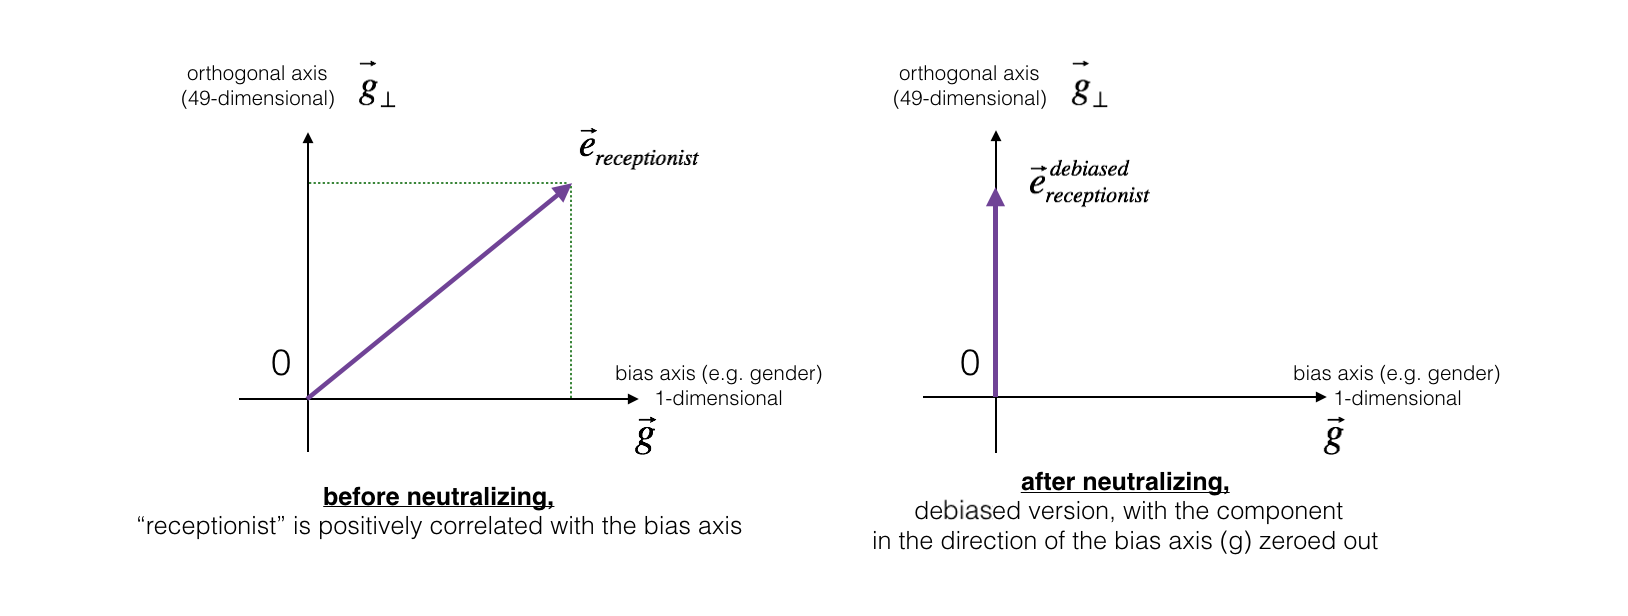

To implement `neutralize()`, given an input embedding $e$, I used the following formulas to compute $e^{debiased}$:

$$e^{bias\_component} = \frac{e \cdot g}{||g||_2^2} * g\tag{2}$$
$$e^{debiased} = e - e^{bias\_component}\tag{3}$$

From linear algebra, $e^{bias\_component}$ is simply the projection of $e$ onto the direction $g$.

In [ ]:
def neutralize(word, g, word_to_vec_map):
    """
    Removes the bias of "word" by projecting it on the space orthogonal to the bias axis.
    This function ensures that gender neutral words are zero in the gender subspace.

    Arguments:
        word -- string indicating the word to debias
        g -- numpy-array of shape (50,), corresponding to the bias axis (such as gender)
        word_to_vec_map -- dictionary mapping words to their corresponding vectors.

    Returns:
        e_debiased -- neutralized word vector representation of the input "word"
    """

    # Select word vector representation of "word". Use word_to_vec_map
    e = word_to_vec_map[word]

    # Compute e_biascomponent using the formula given above.
    e_biascomponent = np.dot(e, g)
    e_biascomponent = e_biascomponent / np.sum(g**2)
    # or e_biascomponent = e_biascomponent / (np.linalg.norm(g)**2)
    e_biascomponent = g * e_biascomponent
    # Note: ^ the dot product is commutative

    # Neutralize e by subtracting e_biascomponent from it
    # e_debiased should be equal to its orthogonal projection
    e_debiased = e - e_biascomponent

    return e_debiased

In [ ]:
e = "receptionist"
print("cosine similarity between " + e + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map["receptionist"], g))

e_debiased = neutralize("receptionist", g, word_to_vec_map)
print("cosine similarity between " + e + " and g, after neutralizing: ", cosine_similarity(e_debiased, g))

cosine similarity between receptionist and g, before neutralizing:  0.3307794175059374
cosine similarity between receptionist and g, after neutralizing:  -4.442232511624783e-17


<a name='5-2'></a>
### 5.2 - Equalization Algorithm for Gender-Specific Words

Next, I wanted to look at how debiasing can also be applied to word pairs such as "actress" and "actor." Equalization is applied to pairs of words that we might want to have differ only through the gender property. As a concrete example, suppose that "actress" is closer to "babysit" than "actor." By applying neutralization to "babysit," we can reduce the gender stereotype associated with babysitting. But this still does not guarantee that "actor" and "actress" are equidistant from "babysit." The equalization algorithm takes care of this.

The key idea behind equalization is to make sure that a particular pair of words are equidistant from the 49-dimensional $g_\perp$. The equalization step also ensures that the two equalized steps are now the same distance from $e_{receptionist}^{debiased}$, or from any other work that has been neutralized. Visually, this is how equalization works:

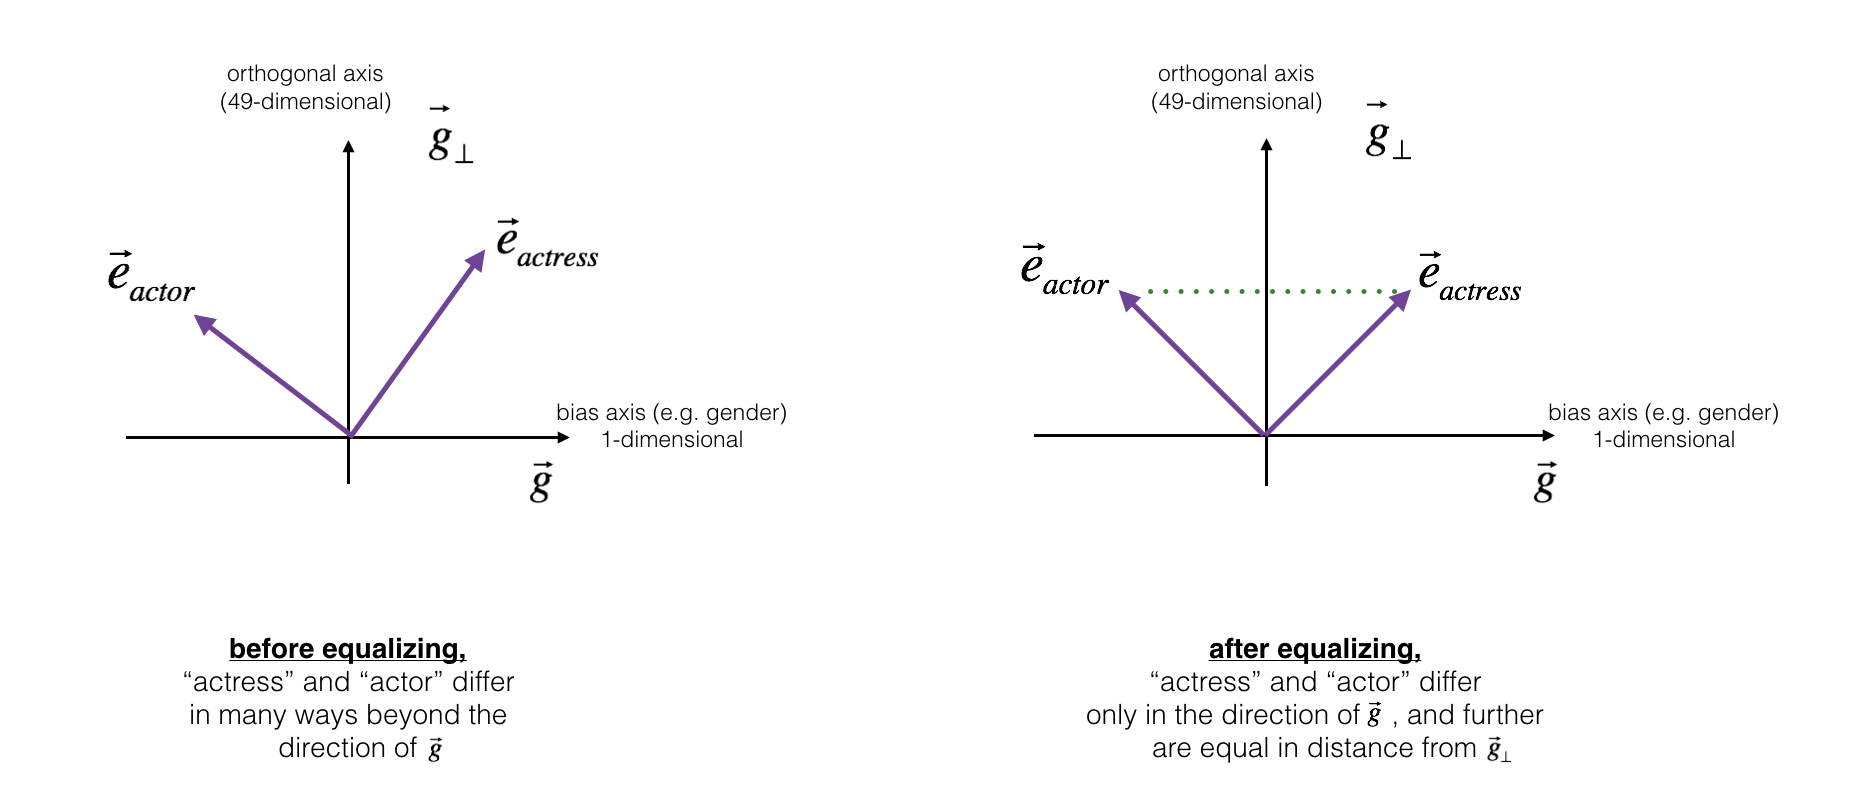

The derivation of from a linear algebra standpoint to achieve this is a bit more complex. (See Bolukbasi et al., 2016 in the References for details.) Here are the key equations:


$$ \mu = \frac{e_{w1} + e_{w2}}{2}\tag{4}$$

$$ \mu_{B} = \frac {\mu \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{5}$$

$$\mu_{\perp} = \mu - \mu_{B} \tag{6}$$

$$ e_{w1B} = \frac {e_{w1} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{7}$$
$$ e_{w2B} = \frac {e_{w2} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{8}$$


$$e_{w1B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w1B}} - \mu_B} {||(e_{w1} - \mu_{\perp}) - \mu_B||_2} \tag{9}$$


$$e_{w2B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w2B}} - \mu_B} {||(e_{w2} - \mu_{\perp}) - \mu_B||_2} \tag{10}$$

$$e_1 = e_{w1B}^{corrected} + \mu_{\perp} \tag{11}$$
$$e_2 = e_{w2B}^{corrected} + \mu_{\perp} \tag{12}$$

In [ ]:
def equalize(pair, bias_axis, word_to_vec_map):
    """
    Debias gender specific words by following the equalize method described in the figure above.

    Arguments:
    pair -- pair of strings of gender specific words to debias, e.g. ("actress", "actor")
    bias_axis -- numpy-array of shape (50,), vector corresponding to the bias axis, e.g. gender
    word_to_vec_map -- dictionary mapping words to their corresponding vectors

    Returns
    e_1 -- word vector corresponding to the first word
    e_2 -- word vector corresponding to the second word
    """

    # Step 1: Select word vector representation of "word". Use word_to_vec_map.
    w1, w2 = pair[0], pair[1]
    e_w1, e_w2 = word_to_vec_map[w1], word_to_vec_map[w2]

    # Step 2: Compute the mean of e_w1 and e_w2
    mu = e_w1/2 + e_w2/2

    # Step 3: Compute the projections of mu over the bias axis and the orthogonal axis
    mu_B = (np.dot(mu, bias_axis)/np.linalg.norm(bias_axis)**2)*bias_axis
    mu_orth = mu - mu_B

    # Step 4: Use equations (7) and (8) to compute e_w1B and e_w2B
    e_w1B = (np.dot(e_w1, bias_axis)*np.linalg.norm(bias_axis)**2)*bias_axis
    e_w2B = (np.dot(e_w2, bias_axis)*np.linalg.norm(bias_axis)**2)*bias_axis

    # Step 5: Adjust the Bias part of e_w1B and e_w2B using the formulas (9) and (10) given above
    corrected_e_w1B = np.sqrt(1 - np.linalg.norm(mu_orth)**2)*((e_w1B - mu_B)/np.abs((e_w1 - mu_orth) - mu_B))
    corrected_e_w2B = np.sqrt(1 - np.linalg.norm(mu_orth)**2)*((e_w2B - mu_B)/np.abs((e_w2 - mu_orth) - mu_B))

    # Step 6: Debias by equalizing e1 and e2 to the sum of their corrected projections
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth

    return e1, e2

In [ ]:
print("cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
print()
e1, e2 = equalize(("man", "woman"), g, word_to_vec_map)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g))

cosine similarities before equalizing:
cosine_similarity(word_to_vec_map["man"], gender) =  -0.11711095765336832
cosine_similarity(word_to_vec_map["woman"], gender) =  0.35666618846270376

cosine similarities after equalizing:
cosine_similarity(e1, gender) =  nan
cosine_similarity(e2, gender) =  nan


These debiasing algorithms are very helpful for reducing bias, but aren't perfect and don't eliminate all traces of bias. For example, one weakness of this implementation was that the bias direction $g$ was defined using only the pair of words _woman_ and _man_. As discussed earlier, if $g$ were defined by computing $g_1 = e_{woman} - e_{man}$; $g_2 = e_{mother} - e_{father}$; $g_3 = e_{girl} - e_{boy}$; and so on and averaging over them, we would obtain a better estimate of the "gender" dimension in the 50 dimensional word embedding space.

<a name='6'></a>
## 6 - References

- The debiasing algorithm is from Bolukbasi et al., 2016, [Man is to Computer Programmer as Woman is to
Homemaker? Debiasing Word Embeddings](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf)
- The GloVe word embeddings were due to Jeffrey Pennington, Richard Socher, and Christopher D. Manning. (https://nlp.stanford.edu/projects/glove/)
